# Projeto 1 - Titanic

## Usar Machine Learning para criar um modelo para fazer uma previsão de qual passageiros sobreviveram no naufrago do Titanic

#### 1. Carregando os Dados

In [110]:
# Instalação das bibliotecas (se necessário)
# !pip install pandas numpy matplotlib seaborn scikit-learn

# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [111]:

# Carregando os datasets
train = pd.read_csv(r"C:\Users\josaf\Documents\Cientista de dados\Curso\data\titanic\train.csv")
test = pd.read_csv(r"C:\Users\josaf\Documents\Cientista de dados\Curso\data\titanic\test.csv")

# Visualizando os primeiros dados
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [112]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


#### 2. Análise Exploratória

In [113]:
# Taxa de sobrevivência geral
print(f"Taxa de sobrevivência: {train['Survived'].mean():.2f}")

Taxa de sobrevivência: 0.38


In [114]:
# Taxa de sobrevivência por sexo
print(train.groupby('Sex')['Survived'].mean())

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


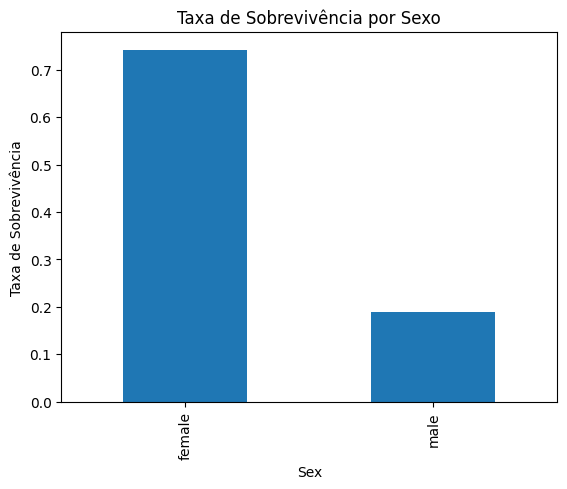

In [115]:
# Visualizando taxa de sobrevivência por sexo
train.groupby('Sex')['Survived'].mean().plot(kind='bar')
plt.title('Taxa de Sobrevivência por Sexo')
plt.ylabel('Taxa de Sobrevivência')
plt.show()

In [116]:
# Taxa de sobrevivência por classe
print(train.groupby('Pclass')['Survived'].mean())

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


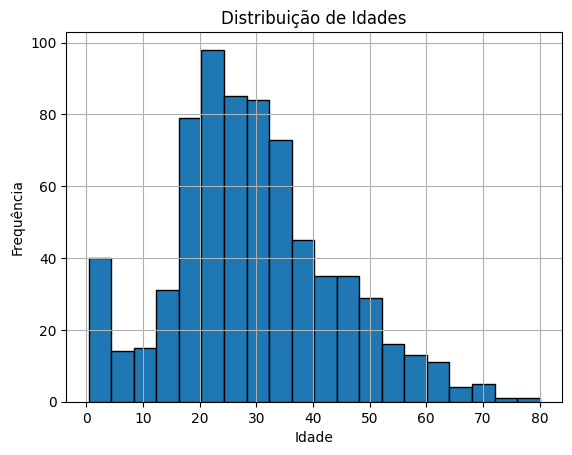

In [117]:
# Histograma de Idade
train['Age'].hist(bins=20, edgecolor='black')
plt.title('Distribuição de Idades')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

#### 3. Preparação dos Dados

In [118]:
# Preenchendo valores ausentes
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
train['Cabin'] = train['Cabin'].fillna('Unknown')

In [119]:
# Transformação de variáveis categóricas
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
train['Embarked'] = train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [120]:
# Selecionando as features mais relevantes
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = train[features]
y = train['Survived']

In [121]:
# Dividindo os dados em treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### 4. Modelagem

In [122]:
# Treinando o modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_val)

# Avaliação do modelo
print("Acurácia:", accuracy_score(y_val, y_pred))
print("Relatório de Classificação:\n", classification_report(y_val, y_pred))


Acurácia: 0.8156424581005587
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85       105
           1       0.79      0.76      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.81      0.82      0.82       179



#### 5. Submissão no Kaggle

In [123]:
# Preprocessando o dataset de teste
test['Age'] = test['Age'].fillna(test['Age'].median())
test['Embarked'] = test['Embarked'].fillna(test['Embarked'].mode()[0])
test['Cabin'] = test['Cabin'].fillna('Unknown')
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})
test['Embarked'] = test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Selecionando features
X_test = test[features]

# Fazendo previsões
test['Survived'] = model.predict(X_test)

# Criando o arquivo de submissão
submission = test[['PassengerId', 'Survived']]
submission.to_csv('submission.csv', index=False)
print("Submissão salva!")


Submissão salva!


#### Resultado da submissão
Resultado: 0.75598

#### 6. Novas Variaveis

In [124]:
# Criando a variável "Tamanho da Família"
train['FamilySize'] = train['SibSp'] + train['Parch']

# Extraindo títulos dos nomes
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
train['Title'] = train['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                                   'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                                   'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace(['Mlle', 'Ms'], 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

# Convertendo Title para valores numéricos
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
train['Title'] = train['Title'].map(title_mapping)

# Atualizando o conjunto de features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']
X = train[features]


#### 7. Tratando Outliers

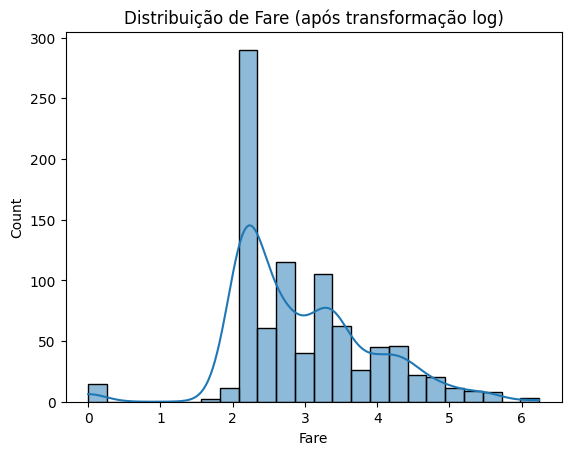

In [125]:
# Lidando com outliers em Fare
train['Fare'] = np.log1p(train['Fare'])  # Aplicando log para suavizar valores altos

# Verificando a distribuição após a transformação
sns.histplot(train['Fare'], kde=True)
plt.title("Distribuição de Fare (após transformação log)")
plt.show()


#### 8. Modelo Gradient Boosting

In [126]:
from xgboost import XGBClassifier

# Treinando o modelo
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Avaliando o modelo
y_pred_xgb = xgb_model.predict(X_val)

print("Acurácia com XGBoost:", accuracy_score(y_val, y_pred_xgb))
print("Relatório de Classificação com XGBoost:\n", classification_report(y_val, y_pred_xgb))


Acurácia com XGBoost: 0.7877094972067039
Relatório de Classificação com XGBoost:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       105
           1       0.74      0.76      0.75        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#### 9. Hiperparâmetros

In [127]:
from sklearn.model_selection import GridSearchCV

# Definindo a grade de parâmetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=XGBClassifier( eval_metric='logloss'),
                           param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Melhor modelo
best_model = grid_search.best_estimator_
print("Melhores Parâmetros:", grid_search.best_params_)

# Avaliando o modelo otimizado
y_pred_best = best_model.predict(X_val)
print("Acurácia com modelo otimizado:", accuracy_score(y_val, y_pred_best))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Melhores Parâmetros: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Acurácia com modelo otimizado: 0.8212290502793296


#### 10. Nova Submissão

In [128]:
print(best_model.feature_names_in_)  # Verificar as features usadas no modelo


['Pclass' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare' 'Embarked']


In [129]:
# Aplicando o modelo otimizado ao conjunto de teste
test['FamilySize'] = test['SibSp'] + test['Parch']
test['Title'] = test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                                 'Jonkheer', 'Dona'], 'Rare')
test['Title'] = test['Title'].replace(['Mlle', 'Ms'], 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')
test['Title'] = test['Title'].map(title_mapping)
test['Fare'] = np.log1p(test['Fare'])  # Aplicando log na tarifa

X_test = test[features]

# Garantindo que X_test contém apenas as colunas utilizadas no treino
X_test = X_test[best_model.feature_names_in_]

# Fazendo previsões
test['Survived'] = best_model.predict(X_test)

# Criando o arquivo de submissão
submission = test[['PassengerId', 'Survived']]
submission.to_csv('submission_optimized.csv', index=False)
print("Submissão otimizada salva!")


Submissão otimizada salva!


#### Nova Submissão
Resultado: 0.77033

#### 11. Mais variaiveis

In [130]:
# Criando novas features baseadas em interações
train['Age*Pclass'] = train['Age'] * train['Pclass']

# Binarizando FamilySize
train['FamilySizeBin'] = pd.cut(train['FamilySize'], bins=[0, 1, 4, 20], labels=[0, 1, 2])

# Fazendo o mesmo para o conjunto de teste
test['Age*Pclass'] = test['Age'] * test['Pclass']
test['FamilySizeBin'] = pd.cut(test['FamilySize'], bins=[0, 1, 4, 20], labels=[0, 1, 2])

# Atualizando o conjunto de features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 
            'FamilySize', 'Title', 'Age*Pclass', 'FamilySizeBin']
X = train[features]
X_test = test[features]


#### 12. Modelo LightGBM

In [131]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

# Treinando o modelo com LightGBM
lgbm_model = LGBMClassifier(random_state=42)
scores = cross_val_score(lgbm_model, X, y, cv=10, scoring='accuracy')

# Média dos scores
print("Acurácia média com LightGBM (cross-validation):", scores.mean())

# Ajustando o modelo aos dados de treino
lgbm_model.fit(X, y)


[LightGBM] [Info] Number of positive: 307, number of negative: 494
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 801, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383271 -> initscore=-0.475688
[LightGBM] [Info] Start training from score -0.475688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMClassifier(random_state=42)

#### 13. Ensemble de Modelos

In [132]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Ajuste nos dados para garantir compatibilidade
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# Certifique-se de que FamilySize está como int ou float
X['FamilySize'] = X['FamilySize'].astype(int)

# Modelos
lgbm_model = LGBMClassifier(enable_categorical=True, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True, random_state=42)
rf_model = RandomForestClassifier(random_state=42)

# Voting ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('lgbm', lgbm_model),
        ('xgb', xgb_model),
        ('rf', rf_model)
    ],
    voting='soft'
)

# Treinamento
ensemble_model.fit(X, y)


[LightGBM] [Warning] Unknown parameter: enable_categorical


C:\Users\josaf\AppData\Local\Temp\ipykernel_16872\2416174154.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['FamilySize'] = X['FamilySize'].astype(int)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:38:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288


VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(enable_categorical=True,
                                             random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_poli...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft')

#### 14. Nova Submissão

In [133]:
# Fazendo previsões no conjunto de teste
test['Survived'] = ensemble_model.predict(X_test)

# Criando o arquivo de submissão
submission = test[['PassengerId', 'Survived']]
submission.to_csv('submission_ensemble.csv', index=False)
print("Submissão com Ensemble salva!")


[LightGBM] [Warning] Unknown parameter: enable_categorical
Submissão com Ensemble salva!


#### Resultado da submissão
Resultado: 0.70574
